In [ ]:
from google.colab import drive
# drive.flush_and_unmount()
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# added to be able to run in Google Colab
import sys
sys.path.append('/content/gdrive/MyDrive/UTRECHT/utils')
sys.path.insert(0,'/content/gdrive/MyDrive/UTRECHT')

import utils

In [ ]:
from __future__ import print_function, division
import os, random, time, copy
from skimage import io, transform, morphology, feature
import numpy as np
import os.path as path
import scipy.io as sio
from scipy import misc
from scipy import ndimage, signal
import scipy
import pickle
import sys
import math
import matplotlib.pyplot as plt
import PIL.Image
from io import BytesIO
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler 
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms

from utils.flow_functions import *

import warnings # ignore warnings
warnings.filterwarnings("ignore")
print(sys.version)
print(torch.__version__)

3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]
2.0.0+cu118


#Setup config parameters
There are several things to setup, like which GPU to use, where to read images and save files, etc. Please read and understand this. By default, you should be able to run this script smoothly by changing nothing.


In [ ]:
### assign directory names  ###
# project_name = 'segDistTransform_v2_2022_02_08_batch4_noNPP'

class_dir = '/content/gdrive/MyDrive/ENSO_project/01_data/05_crops/Finetuning_allSlides/Trial_02/prec_0.5' 
class_dir_test = os.path.join(class_dir, 'test')
class_dir_train = os.path.join(class_dir, 'train')

image_dir_test = os.path.join(class_dir_test, 'Images')
seg_grnd_dir_test = os.path.join(class_dir_test, 'GT_Masks')
seg_pred_dir_test = os.path.join(class_dir_test, 'Pred_Masks')
label_dir_test = os.path.join(class_dir_test, 'Labels')

image_dir_train = os.path.join(class_dir_train, 'Images')
seg_grnd_dir_train = os.path.join(class_dir_train, 'GT_Masks')
seg_pred_dir_train = os.path.join(class_dir_train, 'Pred_Masks')
label_dir_train = os.path.join(class_dir_train, 'Labels')

FP_image_dir_test = os.path.join(class_dir_test, 'False_Det', 'Images')
FP_seg_pred_dir_test = os.path.join(class_dir_test, 'False_Det', 'Pred_Masks')
FP_label_dir_test = os.path.join(class_dir_test, 'False_Det', 'Labels')

FP_image_dir_train = os.path.join(class_dir_train, 'False_Det','Images')
FP_seg_pred_dir_train = os.path.join(class_dir_train, 'False_Det','Pred_Masks')
FP_label_dir_train = os.path.join(class_dir_train,'False_Det', 'Labels')

In [ ]:
def get_immediate_subdirectories(a_dir):
    return [name for name in os.listdir(a_dir)
            if os.path.isdir(os.path.join(a_dir, name))]

In [94]:
### create lists of all samples in train, test, train_FP, test_fp  ###
sampleList_test = []
FP_sampleList_test = []
sampleList_train = []
FP_sampleList_train = []

image_dir_test_dirs = get_immediate_subdirectories(image_dir_test)
for class_dir in (image_dir_test_dirs):
    if class_dir =='u':
        class_dir = os.path.join('u', 'm')
    if class_dir =='a':
        class_dir = os.path.join('a', 'c')
    full_class_dir = os.path.join(image_dir_test, class_dir)
    samples = get_immediate_subdirectories(full_class_dir)
    for sample in samples:        
      a = os.path.join(class_dir,sample)
      if sample != 'labelme':
        sampleList_test.append(a)
      else:
        samples2 = get_immediate_subdirectories(full_class_dir + '/labelme')
        for sample2 in samples2:
          b = os.path.join(class_dir,'labelme', sample2)
          sampleList_test.append(b)
samples = get_immediate_subdirectories(FP_image_dir_test)
for sample in samples:
  if sample != 'labelme':
      FP_sampleList_test.append(sample)   
  else:
    samples2 = get_immediate_subdirectories(FP_image_dir_test + '/labelme')
    for sample2 in samples2:
      b = os.path.join('labelme', sample2)
      FP_sampleList_test.append(b)
image_dir_train_dirs = get_immediate_subdirectories(image_dir_train)
for class_dir in (image_dir_train_dirs):
    if class_dir =='u':
        class_dir = os.path.join('u', 'm')
    if class_dir =='a':
        class_dir = os.path.join('a', 'c')    
    full_class_dir = os.path.join(image_dir_train, class_dir)
    samples = get_immediate_subdirectories(full_class_dir)
    for sample in samples:        
      a = os.path.join(class_dir,sample)
      if sample != 'labelme':
        sampleList_train.append(a)
      else:
        samples2 = get_immediate_subdirectories(full_class_dir + '/labelme')
        for sample2 in samples2:
          b = os.path.join(class_dir,'labelme', sample2)
          sampleList_train.append(b)

samples = get_immediate_subdirectories(FP_image_dir_train)
for sample in samples:
  if sample != 'labelme':
      FP_sampleList_train.append(sample)   
  else:
    samples2 = get_immediate_subdirectories(FP_image_dir_train + '/labelme')
    for sample2 in samples2:
      b = os.path.join('labelme', sample2)
      FP_sampleList_train.append(b)

In [95]:
print(image_dir_train_dirs)

['spo', 'ply', 'aln', 'ind', 'hed', 'che', 'mol', 'aca', 'pod', 'pod_d', 'hup', 'mrs', 'cyp', 'sym', 'poa', 'lyc', 'iso', 'u_m', 'val', 'cec', 'mel', 'cle', 'Daphnopsis', 'ast', 'api_T227', 'pla', 'gun', 'hup_d', 'rap', 'zea', 'iso fragment', 'T166 hooghiemstra', 'eri', 'api', 'dra', 'Selaginella', 'ind_u', 'mon', 'myr', 'fun', 'rubiaceae', 'dod', 'jug', 'tha', 'ind_d', 'vla', 'poa ', 'hed_d', 'proteaceae', 'wei', 'gen', 'ind exclude', 'art', 'T165', 'solanaceae type', 'cf. Eccremocarpus (T127 hooghiemstra)', 'cur', 'jam', 'myrtaceae', 'aln_d', 'cf. polygalaceae', 'ply_d', 'alternanthera', 'alc', 'not pollen', 'hyp', 'hyd', 'rum', 'ast fragment', 'ana', 'symplocos', 'amb', 'typ', 'lupine']


In [96]:
print(len(sampleList_test),len(sampleList_train), len(FP_sampleList_test), len(FP_sampleList_train))
print(os.path.dirname(sampleList_test[0]))

323 1302 310 1312
eri


In [97]:
idx = 100
sliceidx = 4

sample = sampleList_test[idx]
tmplist = sample.split("_")
del tmplist[6]
sample2 = '_'.join(tmplist)

image =  os.path.join(image_dir_test, sample, str(sliceidx) + 'z.png')
seg_grnd = os.path.join(seg_grnd_dir_test, sample2 + '.png')
seg_pred = os.path.join(seg_pred_dir_test, sample2 + '.png')
# trtsSetIdx = trtsSet[idx]
# label = os.path.join(label_dir_test, sample + '.csv'

image = PIL.Image.open(image)
seg_grnd = PIL.Image.open(seg_grnd)
seg_pred = PIL.Image.open(seg_pred)
image = np.array(image)
seg_grnd = np.array(seg_grnd)
seg_pred = np.array(seg_pred)

In [98]:
print(sample)

aln/PAL1999_B2_sample71_slide1_30009x_9550y_0.82_1


Text(0.5, 1.0, 'seg_pred')

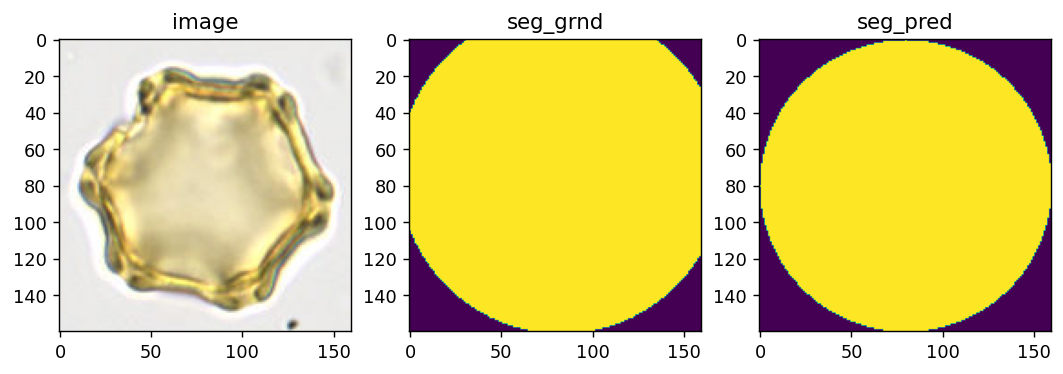

In [99]:
numSample2Show = 1
figWinNumHeight, figWinNumWidth = 1, 3
plt.figure(figsize=(10, 3), dpi=128, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1    

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(image)
#plt.axis('off')
plt.title('image')

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(seg_grnd)
#plt.axis('off')
plt.title('seg_grnd')

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(seg_pred)
#plt.axis('off')
plt.title('seg_pred')

In [100]:
### Assign ID's to classes. Tensor reads labels as float? values  ###

# species_codes = pd.read_excel('/content/gdrive/MyDrive/UTRECHT/Class/Species_Code.xlsx', index_col=0)
# species_codes_dict = dict(zip(species_codes.Code,species_codes.index))

select_taxa = ['aln','poa','pod','hup','ply','lyc']

In [101]:
species_codes_dict = {}

for i in range(len(select_taxa)):
  species_codes_dict.update({select_taxa[i]:i})

species_codes_dict.update({'other':len(select_taxa)})

print(species_codes_dict)
# species_codes_dict.get('poa')

{'aln': 0, 'poa': 1, 'pod': 2, 'hup': 3, 'ply': 4, 'lyc': 5, 'other': 6}


In [102]:
classes_train = []
classes_test = []
remove = ['ind','375', 'fun', 't58','t22','dia','ttr','ped','t47','p16','glo','p17','gel','spr','p2','neu','u4','u16','u17','his','u30','u45','peo','azo']
for class_dir in (image_dir_train_dirs):
    if class_dir in remove:
        continue
    if class_dir in select_taxa:
      classes_train.append(class_dir)

for class_dir in (image_dir_test_dirs):
    if class_dir in remove:
        continue
    if class_dir in select_taxa:
      classes_test.append(class_dir)

In [103]:
classes_all = []
classes_all += classes_train
classes_all += classes_test
classes_all = sorted(list(set(classes_all)))
print(classes_all)
print(len(classes_all))

['aln', 'hup', 'lyc', 'ply', 'poa', 'pod']
6


In [104]:
species_codes_dict = {}
for idx in range(len(classes_all)):
    code = classes_all[idx]
    species_codes_dict.update({code:idx})

In [105]:
num_class = len(classes_all)
species_codes_dict.update({'Other':num_class})
species_codes_dict.update({'False_det':num_class+1})
print(species_codes_dict)

{'aln': 0, 'hup': 1, 'lyc': 2, 'ply': 3, 'poa': 4, 'pod': 5, 'Other': 6, 'False_det': 7}


In [106]:
sample = sampleList_train[0]
classID = sample.split("/")[0]

print(sample)
print(classID)

spo/labelme/PAL1999_C6_sample1_slide2_41392x_42080y_0.71_1
spo


In [119]:
train_cls_imgList = []
test_cls_imgList = []
train_cls_grndMaskList = []
test_cls_grndMaskList = []
train_cls_predMaskList = []
test_cls_predMaskList = []
train_cls_className = []
test_cls_className = []
# train_binary_cls_classID = []
# test_binary_cls_classID = []
train_kway_cls_classID = []
test_kway_cls_classID = []

train_cls_list = []
test_cls_list = []

perClassCount = [0]*(num_class+2)
# perClassCount = [0]*2

for i in range(len(sampleList_train)):    
    sample = sampleList_train[i]  
    # if os.path.dirname(sample) in remove:
    #     continue
    
    tmplist = sample.split("_")
    del tmplist[-2]
    sample2 = '_'.join(tmplist)

    train_cls_imgList.append(os.path.join(image_dir_train, sample))
    train_cls_grndMaskList.append(os.path.join(seg_grnd_dir_train, sample2 + '.png'))
    train_cls_predMaskList.append(os.path.join(seg_pred_dir_train, sample2 + '.png'))

    tmpclassName = sample.split("/")[0]
    if species_codes_dict.get(tmpclassName) is None:
      tmpclassName = 'Other'
    train_cls_className.append(tmpclassName)
    classID = species_codes_dict.get(tmpclassName)

    train_kway_cls_classID.append(classID)
    # train_binary_cls_classID.append(1)
    perClassCount[train_kway_cls_classID[i]] += 1

for i in range(len(sampleList_test)):
    sample = sampleList_test[i]    
    # if os.path.dirname(sample) in remove:
    #     continue  
    tmplist = sample.split("_")
    del tmplist[-2]
    sample2 = '_'.join(tmplist)

    test_cls_imgList.append(os.path.join(image_dir_test, sample))
    test_cls_grndMaskList.append(os.path.join(seg_grnd_dir_test, sample2 + '.png'))
    test_cls_predMaskList.append(os.path.join(seg_pred_dir_test, sample2 + '.png'))

    tmpclassName = sample.split("/")[0]
    test_cls_className.append(tmpclassName)
    if species_codes_dict.get(tmpclassName) is None:
      tmpclassName = 'Other'
    classID = species_codes_dict.get(tmpclassName)

    test_kway_cls_classID.append(classID) 
    # test_binary_cls_classID.append(1)  

for i in range(len(FP_sampleList_train)):
    sample = FP_sampleList_train[i]  

    tmplist = sample.split("_")
    del tmplist[-2]
    sample2 = '_'.join(tmplist)

    train_cls_imgList.append(os.path.join(FP_image_dir_train, sample))
    # train_cls_grndMaskList.append(os.path.join(FP_seg_grnd_dir_train, sample + '.bmp'))
    train_cls_predMaskList.append(os.path.join(FP_seg_pred_dir_train, sample2 + '.png'))
    train_cls_className.append('False_det')
    train_kway_cls_classID.append(species_codes_dict.get('False_det'))
    # train_binary_cls_classID.append(0)
    perClassCount[species_codes_dict.get('False_det')] += 1
    # perClassCount[0] += 1

for i in range(len(FP_sampleList_test)):
    sample = FP_sampleList_test[i]      

    tmplist = sample.split("_")
    del tmplist[-2]
    sample2 = '_'.join(tmplist)
            
    test_cls_imgList.append(os.path.join(FP_image_dir_test, sample))
    # test_cls_grndMaskList.append(os.path.join(seg_grnd_dir_test, sample + '.bmp'))
    test_cls_predMaskList.append(os.path.join(FP_seg_pred_dir_test, sample2 + '.png'))
    test_cls_className.append('False_det')
    test_kway_cls_classID.append(species_codes_dict.get('False_det')) 
    # test_binary_cls_classID.append(0)

print(len(train_cls_imgList), len(test_cls_imgList))

2614 633


In [120]:
print(test_cls_predMaskList)

['/content/gdrive/MyDrive/ENSO_project/01_data/05_crops/Finetuning_allSlides/Trial_02/prec_0.5/test/Pred_Masks/eri/PAL1999_C1_sample55_slide1_103666x_11481y_1.png', '/content/gdrive/MyDrive/ENSO_project/01_data/05_crops/Finetuning_allSlides/Trial_02/prec_0.5/test/Pred_Masks/eri/PAL1999_C1_sample55_slide1_88343x_50174y_1.png', '/content/gdrive/MyDrive/ENSO_project/01_data/05_crops/Finetuning_allSlides/Trial_02/prec_0.5/test/Pred_Masks/eri/PAL1999_C1_sample15_slide1_49828x_49279y_1.png', '/content/gdrive/MyDrive/ENSO_project/01_data/05_crops/Finetuning_allSlides/Trial_02/prec_0.5/test/Pred_Masks/iso/PAL1999_C1_sample55_slide1_103666x_11481y_1.png', '/content/gdrive/MyDrive/ENSO_project/01_data/05_crops/Finetuning_allSlides/Trial_02/prec_0.5/test/Pred_Masks/iso/labelme/PAL1999_C3_sample43_slide1_37584x_68640y_1.png', '/content/gdrive/MyDrive/ENSO_project/01_data/05_crops/Finetuning_allSlides/Trial_02/prec_0.5/test/Pred_Masks/iso/labelme/PAL1999_C6_sample1_slide2_55312x_57680y_1.png', '/co

In [121]:
dbinfo = {}
# dbinfo['meta'] = mapping
dbinfo['perClassCount'] = perClassCount
dbinfo['train_cls_imgList'] = train_cls_imgList
dbinfo['train_cls_grndMaskList'] = train_cls_grndMaskList
dbinfo['train_cls_predMaskList'] = train_cls_predMaskList
dbinfo['train_cls_className'] = train_cls_className
# dbinfo['train_cls_classID'] = train_binary_cls_classID 
dbinfo['train_kway_cls_classID'] = train_kway_cls_classID

dbinfo['test_cls_imgList'] = test_cls_imgList
dbinfo['test_cls_grndMaskList'] = test_cls_grndMaskList
dbinfo['test_cls_predMaskList'] = test_cls_predMaskList
dbinfo['test_cls_className'] = test_cls_className
# dbinfo['test_cls_classID'] = test_binary_cls_classID 
dbinfo['test_kway_cls_classID'] = test_kway_cls_classID

dbinfo['species_codes_dict'] = species_codes_dict

# with open('/content/gdrive/MyDrive/UTRECHT/Class/segDistTransform_v2_2022_02_08_batch4_noNPP/dbinfo_binary_cls_stacks.plk', 'wb') as handle:
#     pickle.dump(dbinfo, handle) # , protocol=pickle.HIGHEST_PROTOCOL

In [122]:
cls_dir = '/content/gdrive/MyDrive/ENSO_project/03_cls'
trials = ['Trial_01']

cls_exp_dir = os.path.join(cls_dir, 'exp', trials[0])

if not os.path.exists(cls_exp_dir):
  os.makedirs(cls_exp_dir)

with open(os.path.join(cls_exp_dir, 'dbinfo.pkl'), 'wb') as handle:
    pickle.dump(dbinfo, handle) # , protocol=pickle.HIGHEST_PROTOCOL

In [123]:
with open(os.path.join(cls_exp_dir, 'dbinfo.pkl'), 'rb') as handle:
    dbinfo = pickle.load(handle)

dbinfo.keys(), len(dbinfo['train_cls_imgList']), len(dbinfo['test_cls_imgList'])

(dict_keys(['perClassCount', 'train_cls_imgList', 'train_cls_grndMaskList', 'train_cls_predMaskList', 'train_cls_className', 'train_kway_cls_classID', 'test_cls_imgList', 'test_cls_grndMaskList', 'test_cls_predMaskList', 'test_cls_className', 'test_kway_cls_classID', 'species_codes_dict']),
 2614,
 633)

In [112]:
print(dbinfo['species_codes_dict'])

{'aln': 0, 'hup': 1, 'lyc': 2, 'ply': 3, 'poa': 4, 'pod': 5, 'Other': 6, 'False_det': 7}


In [113]:
idx =  71
sliceidx = 3
image = dbinfo['train_cls_imgList'][idx]
image =  os.path.join(dbinfo['train_cls_imgList'][idx], str(sliceidx) + 'z.png')
seg_grnd = dbinfo['train_cls_grndMaskList'][idx]
seg_pred = dbinfo['train_cls_predMaskList'][idx]

# label = dbinfo['train_cls_classID'][idx]
# labelName = dbinfo['meta'][label-1]
class_name = dbinfo['train_cls_className'][idx]

image = PIL.Image.open(image)
seg_grnd = PIL.Image.open(seg_grnd)
seg_pred = PIL.Image.open(seg_pred)
image = np.array(image)
seg_grnd = np.array(seg_grnd)
seg_pred = np.array(seg_pred)

Text(0.5, 1.0, 'seg_pred')

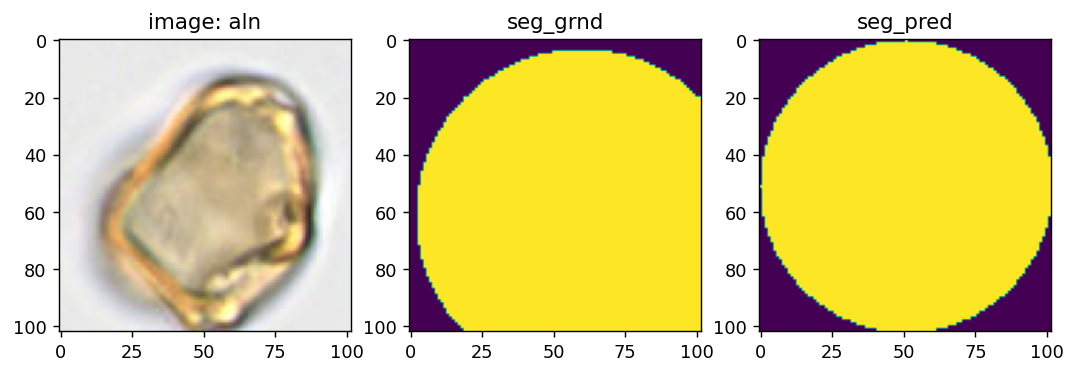

In [114]:
numSample2Show = 1
figWinNumHeight, figWinNumWidth = 1, 3
plt.figure(figsize=(10, 3), dpi=128, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1    


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(image)
#plt.axis('off')
plt.title('image: '+class_name)


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(seg_grnd)
#plt.axis('off')
plt.title('seg_grnd')

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(seg_pred)
#plt.axis('off')
plt.title('seg_pred')

In [ ]:
# if pred_mask is zero-bytes, delete file and replace with GT mask

In [125]:
for i in train_cls_predMaskList:
  if os.path.getsize(i) ==0:
    print(i)

/content/gdrive/MyDrive/ENSO_project/01_data/05_crops/Finetuning_allSlides/Trial_02/prec_0.5/train/Pred_Masks/iso/labelme/PAL1999_C3_sample1_slide2_40000x_41040y_1.png


In [126]:
for i in test_cls_predMaskList:
  if os.path.getsize(i) ==0:
    print(i)